In [1]:
import sys

# Para podermos importar o utils
sys.path.append("../")

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import pacf, acf
from sklearn.metrics import mean_absolute_error
from scipy.stats import gaussian_kde
from datetime import datetime, timedelta
from utils import wrangle_data

In [4]:
# importando dados já limpos (sem duplicatas e com deltas)
data = pd.read_csv("../data/vacinados_clean.csv", parse_dates=["Data"])
data.head()

,Data,Vacinados,Delta
0,2021-01-19 11:16:00,3908,NaN
1,2021-01-20 14:14:00,17318,13410.0
2,2021-01-20 15:11:00,18409,1091.0
3,2021-01-20 15:19:00,18729,320.0
4,2021-01-20 15:24:00,18834,105.0


In [5]:
"""
Separamos treino e teste antes de fazer o tratamento para que calculos como média e desvio padrão
não vazem informações de um conjunto para outro
"""
# 75/25
train_split = int(data.shape[0] * 0.75)
train, test = data.iloc[:train_split], data.iloc[train_split:]

train = wrangle_data(train)
test = wrangle_data(test)

# Modelo Sarima

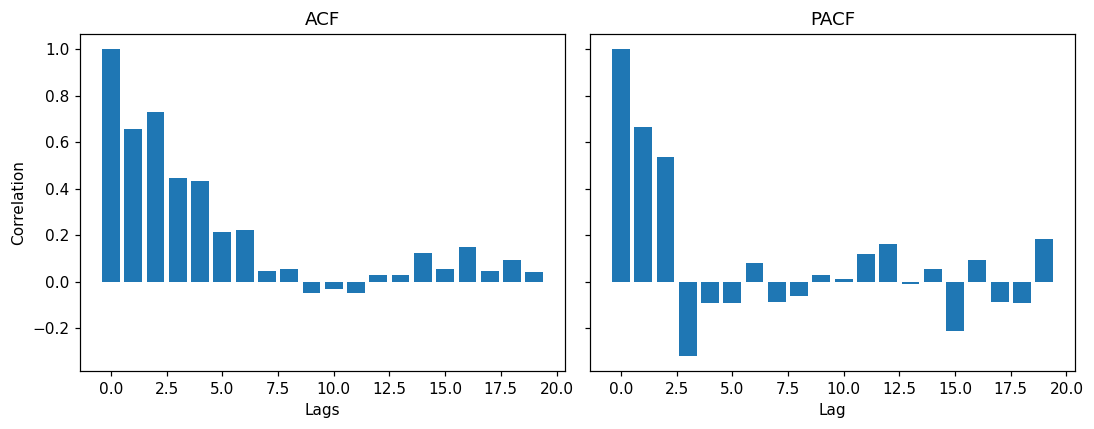

In [6]:
first_diff = train.diff()[1:]
num_lags = 20
acf_vals = acf(first_diff, nlags=num_lags, fft=False)
pacf_vals = pacf(first_diff, nlags=num_lags)

fig, ax = plt.subplots(ncols=2, figsize=(10,4), dpi=110, sharey=True)

ax[0].bar(range(num_lags), acf_vals[:num_lags])
ax[0].set(title="ACF",
         xlabel="Lags",
         ylabel="Correlation")

ax[1].bar(range(num_lags), pacf_vals[:num_lags])
ax[1].set(title="PACF",
         xlabel="Lag")
fig.tight_layout();

In [7]:
"""
Parametros q vamos utilizar em todos as otimizações feitas

method: método de otimização, escolhi um método derivative-free para evitar q regiões planas
ou com vários minimos impeçam o modelo de convergir

https://stats.stackexchange.com/questions/313426/mle-convergence-errors-with-statespace-sarimax

maxiter: máximo de iterações antes de parar a otimização, 150 só pra garantir (padrão é 50)

disp: desliga o relatório da otimização
"""
opt_param = {'method': 'powell', 'maxiter':150, 'disp':0}


# Treina um modelo com os parametros passados e calcula o MAE no conjunto de testes
def train_score_sarima(order, seasonal_order, train, test):
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order)
    fit  = model.fit(**opt_param)
    predictions = fit.forecast(len(test))
    return mean_absolute_error(test, predictions)

# Fixa (p,q,d) e (P,Q,D) e percorre uma lista de parametros m tentando encontrar o de menor erro
def search_seasonal_period(order, P, Q, D, train, test, periods):
    best_score = None
    best_m = None
    for m in periods:
        score = train_score_sarima(order, (P,Q,D,m), train, test)
        if best_score is None or score < best_score:
            best_m, best_score = m, score
    return best_m, best_score

In [8]:
"""
AR: 6 pelo gráfico de auto-correlação 
I: 1 porque fazer Lag-1 (coluna Delta) nos dá uma série estacionária
MA: 1 Termo de média móvel, sem fundamento pra escolha aqui, só chutei
Vamos deixar essa parte do modelo fixa por enquanto
"""
order=(6,1,1)
best_m, best_score = search_seasonal_period(order, 1,1,1, list(train), list(test), range(16,30))
best_m, best_score

/home/victorcapone/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/victorcapone/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/victorcapone/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/victorcapone/miniconda3/envs/vacinometro/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average U

(19, 16366.17011202563)

In [9]:
"""
AR, I e MA 1 e parametro de sazonalidade igual ao melhor encontrado na célula de cima (best_m)
algo perto de 24 porque num periodo de 24h temos um ciclo de vacinação começando devagar na parte da
manhã, acelerando na hora do almoço e começo da tarde e diminuindo no final do dia
"""
season_order=(1, 1, 1, best_m)
"""
Faz o rolling forecast, prevendo sempre o próximo periodo e adicionando o
valor real ao próximo conjunto de treino dos dados
"""
def rolling_forecast(order, seasonal_order, train, test):
    forecasts = []
    
    initial = train.index.max()
    #Cópia local para não afetar objetos passados
    train_copy = list(train).copy()
    test_copy = list(test).copy()
    for obs in range(len(test_copy)):
        model = SARIMAX(train_copy, order=order, season_order=seasonal_order)
        fit = model.fit(**opt_param)
        prediction = fit.forecast(initial+obs)
        forecasts.append(prediction[0])
        # Adiciona o primeiro do conjunto de teste ao final do conjunto de treino
        train_copy.append(test_copy[0])
        test_copy = test_copy[1:]
    return forecasts

rolling = rolling_forecast(order, season_order, train, test)

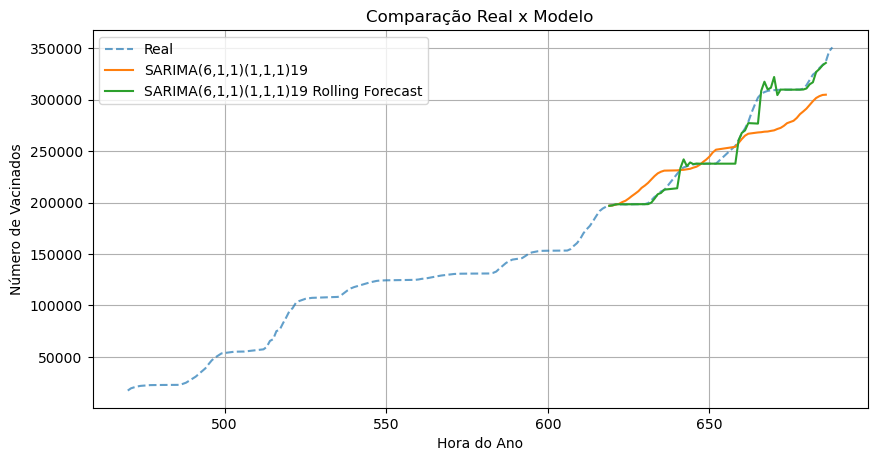

In [10]:
model = SARIMAX(list(train), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)

full_data = wrangle_data(data)

predictions = model_fit.forecast(len(test))
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(full_data.index, full_data, linestyle='--', alpha =0.7, label="Real")
ax.plot(test.index, predictions, label=f"SARIMA(6,1,1)(1,1,1){best_m}");
ax.plot(test.index, rolling, label=f"SARIMA(6,1,1)(1,1,1){best_m} Rolling Forecast")
ax.set(title=f"Comparação Real x Modelo",
       xlabel="Hora do Ano",
       ylabel="Número de Vacinados")
ax.grid()
ax.legend();

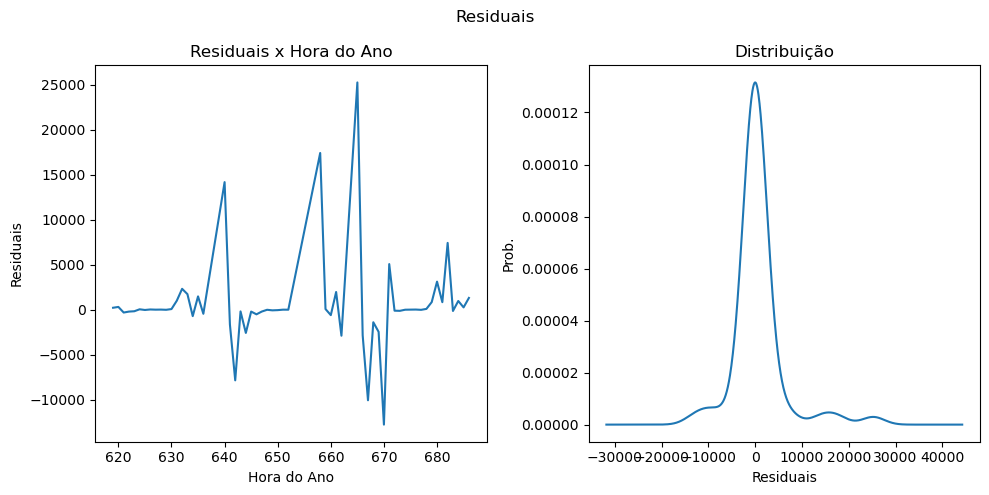

In [11]:
# Computa os residuais
residuals = pd.Series(test - np.array(rolling))
# Gaussaibn Kernel Density Estimation para os nossos residuais
kde = gaussian_kde(residuals)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

fig.suptitle("Residuais")

ax[0].set(title="Residuais x Hora do Ano",
         xlabel="Hora do Ano",
         ylabel="Residuais")

ax[0].plot(residuals)

residuals.plot(kind='kde', ax=ax[1])

ax[1].set(title="Distribuição",
         xlabel="Residuais",
         ylabel="Prob.")
fig.tight_layout()


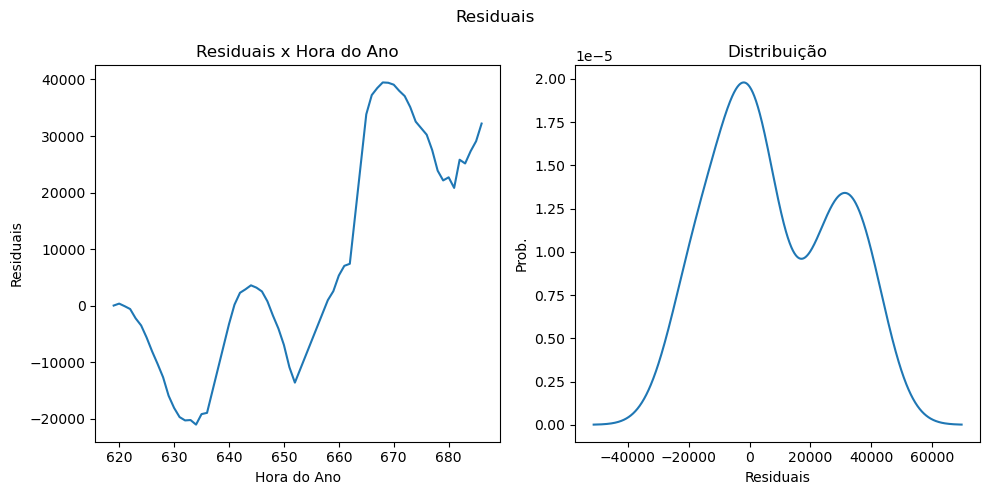

In [12]:
# Computa os residuais
residuals = pd.Series(test - np.array(predictions))
# Gaussaibn Kernel Density Estimation para os nossos residuais
kde = gaussian_kde(residuals)

fig, ax = plt.subplots(ncols=2, figsize=(10,5), dpi=100)

fig.suptitle("Residuais")

ax[0].set(title="Residuais x Hora do Ano",
         xlabel="Hora do Ano",
         ylabel="Residuais")

ax[0].plot(residuals)

residuals.plot(kind='kde', ax=ax[1])

ax[1].set(title="Distribuição",
         xlabel="Residuais",
         ylabel="Prob.")
fig.tight_layout()

In [13]:
residuals.describe()

count       57.000000
mean      8069.366878
std      19616.843652
min     -21003.716362
25%      -5615.881434
50%       2530.409695
75%      27316.262565
max      39468.125032
Name: Vacinados, dtype: float64

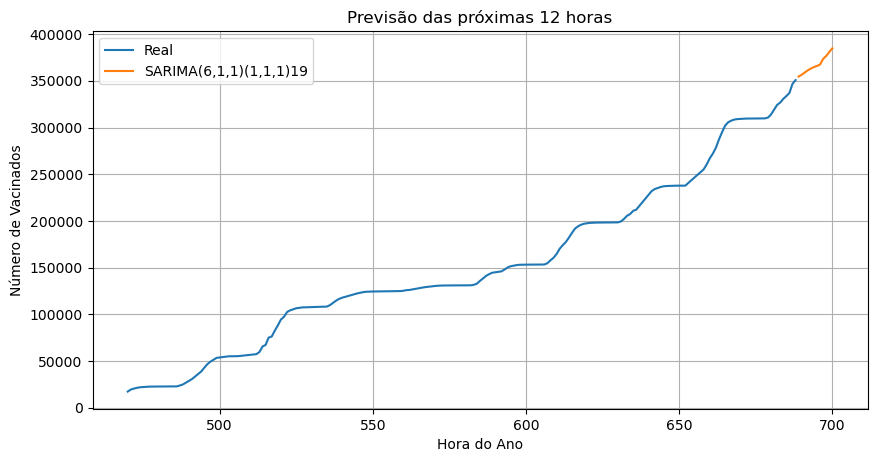

In [14]:
"""
Treinando um modelo com o melhor parametro de sazonalidade encontrado para tentar 
prever número de vacinados nas próximas horas
"""
order=(6,1,1)
season_order=(1, 1, 1, best_m)
model =SARIMAX(list(full_data), order=order, seasonal_order=season_order)
model_fit = model.fit(**opt_param)
hours_to_predict = 12
predictions = model_fit.forecast(hours_to_predict)
index = range(full_data.index.max()+1, full_data.index.max()+hours_to_predict+1)
fig, ax = plt.subplots(figsize=(10,5), dpi=100)

ax.plot(full_data.index, full_data, label="Real")
ax.plot(index, predictions, label=f"SARIMA(6,1,1)(1,1,1){best_m}");
ax.set(title=f"Previsão das próximas {hours_to_predict} horas",
       xlabel="Hora do Ano",
       ylabel="Número de Vacinados")
ax.grid()
ax.legend();

In [15]:
hora_zero = datetime(2021, 1, 1)
last_real_data = int(full_data.index.max())

print(f"Previsão de 12h a partir de {hora_zero + timedelta(hours=last_real_data)}")
for hora, vac in zip(index, predictions):
    data_vac = hora_zero + timedelta(hours=hora)
    print(f"{data_vac}: {vac:.0f}")

Previsão de 12h a partir de 2021-01-29 16:00:00
2021-01-29 17:00:00: 354572
2021-01-29 18:00:00: 356492
2021-01-29 19:00:00: 358877
2021-01-29 20:00:00: 361183
2021-01-29 21:00:00: 363135
2021-01-29 22:00:00: 364696
2021-01-29 23:00:00: 365918
2021-01-30 00:00:00: 367380
2021-01-30 01:00:00: 373422
2021-01-30 02:00:00: 376557
2021-01-30 03:00:00: 380787
2021-01-30 04:00:00: 384714
